In [1]:
import numpy as np
import pymatching
import scipy.optimize
import stim
from matplotlib import pyplot as plt

In [2]:
def count_logical_errors(circuit: stim.Circuit, shots: int) -> float:
    sampler = circuit.compile_detector_sampler()
    detection_events, observable_flips = sampler.sample(shots, separate_observables=True)

    detector_error_model = circuit.detector_error_model(decompose_errors=True)
    matcher = pymatching.Matching.from_detector_error_model(detector_error_model)

    predictions = matcher.decode_batch(detection_events)
    return np.any(observable_flips != predictions, axis=1).mean()

In [3]:
def calc(
    distance: int, rounds: int, shots: int = 10**4, batches: int = 10
) -> tuple[float, float]:
    circuit = stim.Circuit.generated(
        "repetition_code:memory",
        distance=distance,
        rounds=rounds,
        before_round_data_depolarization=0.04,
        before_measure_flip_probability=0.04,
    )
    res = [count_logical_errors(circuit, shots) for _ in range(batches)]
    return np.mean(res), np.std(res)

rounds = 50
distances = np.arange(3, 12, 2)
%time res = np.array([[calc(d, r + 1, 20000, 10) for r in range(rounds)] for d in distances])
print(res.shape)

CPU times: user 3min 13s, sys: 2.17 s, total: 3min 15s
Wall time: 3min 17s
(5, 50, 2)


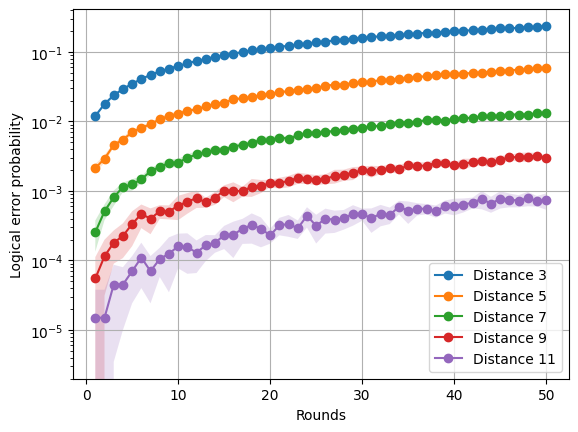

In [4]:
for i in range(len(distances)):
    y = res[i, :, 0]
    y1, y2 = y - res[i, :, 1], y + res[i, :, 1]
    plt.semilogy(np.arange(rounds) + 1, y, marker='o', label=f'Distance {distances[i]}')
    plt.fill_between(np.arange(rounds) + 1, y1, y2, alpha=0.2)
plt.xlabel("Rounds")
plt.ylabel("Logical error probability")
plt.legend()
plt.grid()
plt.show()

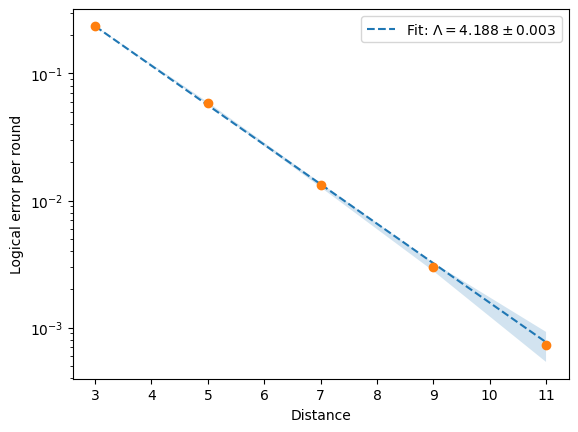

In [5]:
def fit(d, Λ, C):
    return C / Λ ** ((d + 1) / 2)

y, y_err = res[:, -1, 0], res[:, -1, 1]
popt, pcov = scipy.optimize.curve_fit(fit, distances, y, sigma=y_err, absolute_sigma=True)

plt.semilogy(distances, fit(distances, *popt), "--", label=f"Fit: $\\Lambda = {popt[0]:.3f}\\pm{pcov[0, 0]:.3f}$")
plt.semilogy(distances, y, "o")
plt.fill_between(distances, y - y_err, y + y_err, alpha=0.2)
plt.xlabel("Distance")
plt.ylabel("Logical error per round")

plt.legend()
plt.show()